### Bibliotecas

In [28]:
import os
import pandas as pd
import re
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches



### Parâmetros

In [9]:
# Diretório raiz informado
diretorio_raiz = '/Volumes/MiniArmstro/Resultados' 

caminho_status = os.path.join(diretorio_raiz, 'status_pacotes.csv')

# Subprefeituras
subprefeituras = [
    'CASA VERDE-CACHOEIRINHA', 'LAPA', 'SE', 'SANTANA-TUCURUVI',
    'PINHEIROS', 'VILA MARIA-VILA GUILHERME', 'MOOCA',
    'SAO MIGUEL', 'ARICANDUVA-FORMOSA-CARRAO', 'SANTO AMARO'
]

subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'

verbose = True

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/Tabelas_Site_OD2023_120225.xlsx'
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, sheet_name='tab25', index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

blue = "\033[34m"
reset = "\033[0m"

### Listando pacotes

In [8]:
# Se o arquivo já existir, carregue-o
if os.path.exists(caminho_status):
    print("Arquivo de status encontrado. Carregando...")
    df_status_pacotes = pd.read_csv(caminho_status, index_col=0)

else:
    print("Arquivo de status não encontrado. Criando novo...")

    # Encontrar subdiretórios que seguem o padrão "Pacote_XX"
    pacotes = []
    for item in os.listdir(diretorio_raiz):
        caminho_completo = os.path.join(diretorio_raiz, item)
        if os.path.isdir(caminho_completo) and re.match(r'^Pacote_\d{2}$', item):
            pacotes.append(item)

    # Criar o DataFrame com zeros
    df_status_pacotes = pd.DataFrame(0, index=sorted(pacotes), columns=subprefeituras)

    # Salvar para uso futuro
    df_status_pacotes.to_csv(caminho_status)
    print(f"Arquivo de status criado: {caminho_status}")

# Selecionar a sub-prefeitura a ser processada
subprefeitura = subprefeituras[1]
print(f"Sub-prefeitura selecionada: {subprefeitura}")


Arquivo de status encontrado. Carregando...
Sub-prefeitura selecionada: LAPA


### Carregando os pontos OD

Bounding boxes geradas com sucesso!


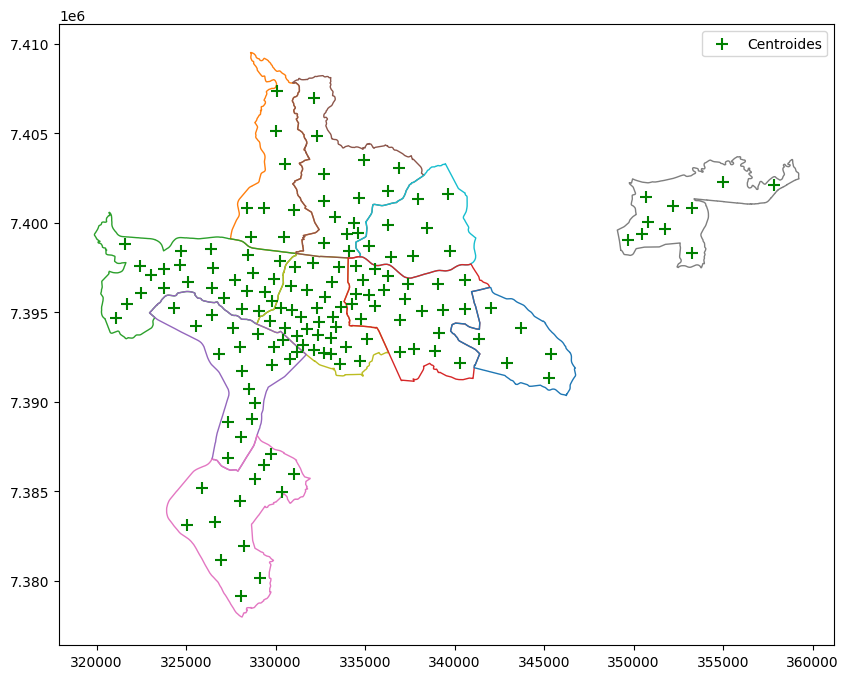

In [15]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior índice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="Média", ascending=False).head(10)
#TODO Explicar bem esse critério dentro do capítulo de método

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

gdf_zonas_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# Atribuição do esquema de projeção
gdf_zonas_OD_2023_utm = gdf_zonas_OD_2023.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_2023_utm[gdf_zonas_OD_2023_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_zonas_OD_SP_2023_utm["centroid"] = gdf_zonas_OD_SP_2023_utm["geometry"].centroid

# Garantir que ambos os GeoDataFrames têm o mesmo CRS
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_SP_2023_utm.to_crs(gdf_sp_filtrado.crs)

# Filtrar apenas os centroides que estão dentro das subprefeituras selecionadas
centroids = gdf_zonas_OD_SP_2023_utm['centroid']
centroids_filtrados = centroids[centroids.within(gdf_sp_filtrado.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as subprefeituras
gdf_sp_filtrado.plot(ax=ax, column='sp_nome', facecolor='none', linewidth=1)

# Extraindo coordenadas dos centroides filtrados
x = centroids_filtrados.x
y = centroids_filtrados.y

# Plotar os centroides filtrados como estrelas (*)
ax.scatter(x, y, color='green', marker='+', s=70, label="Centroides")

# Adicionar legenda
ax.legend()

# Exibir o mapa
plt.show()

In [22]:
gdf_sp_filtrado

,sp_areamt,sp_areakmt,sp_codigo,sp_id,sp_sigla,sp_nome,geometry
1,27232342.53,27.0,04,3.0,CV,CASA VERDE-CACHOEIRINHA,"POLYGON ((329084.795 7402363.669, 329086.123 7..."
2,40638699.56,41.0,08,13.0,LA,LAPA,"POLYGON ((321633.729 7393535.365, 321633.031 7..."
4,26665465.09,27.0,09,14.0,SE,SE,"POLYGON ((330197.017 7396087.885, 330211.849 7..."
5,35782518.58,36.0,05,4.0,ST,SANTANA-TUCURUVI,"POLYGON ((334076.366 7398045.594, 334074.986 7..."
6,31993530.49,32.0,11,22.0,PI,PINHEIROS,"POLYGON ((327871.085 7386152.364, 327865.295 7..."
8,26899223.48,27.0,07,6.0,MG,VILA MARIA-VILA GUILHERME,"POLYGON ((336762.078 7401144.267, 336794.867 7..."
9,36046910.58,36.0,25,15.0,MO,MOOCA,"POLYGON ((334126.109 7396389.068, 334125.831 7..."
14,26159228.21,26.0,23,9.0,MP,SAO MIGUEL,"POLYGON ((352480.323 7397515.871, 352477.052 7..."
16,22335715.74,22.0,26,16.0,AF,ARICANDUVA-FORMOSA-CARRAO,"POLYGON ((341388.453 7394169.562, 341389.571 7..."
25,37745316.90,38.0,14,29.0,SA,SANTO AMARO,"POLYGON ((327892.375 7386141.134, 327896.575 7..."


CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983
Grafo obtido com sucesso!
Sub-prefeitura selecionada:  LAPA


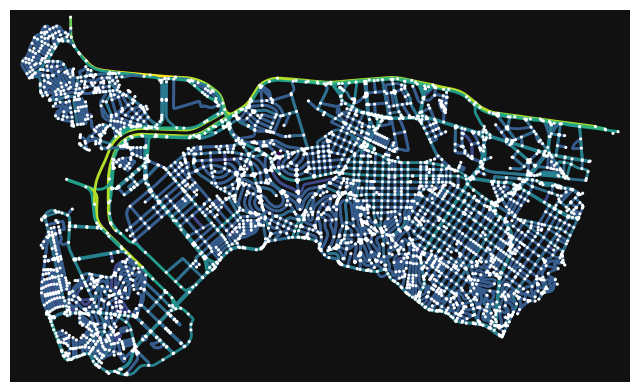

In [26]:
# Dados da subprefeitura
indice_sp = gdf_sp_filtrado[gdf_sp_filtrado['sp_nome'] == subprefeitura].index[0]
nome_sp = subprefeitura

# Verifica e define o CRS
if gdf_sp_filtrado.crs is None:
    gdf_sp_filtrado.set_crs(epsg=4326, inplace=True)  # Define como WGS 84 (latitude/longitude)

# Extrai a geometria
poligono = gdf_sp_filtrado.iloc[indice_sp].geometry

# Certifique-se de que o polígono está em EPSG:4326 (necessário para OSMNX)
if gdf_sp_filtrado.crs.to_epsg() != 4326:
    poligono = gdf_sp_filtrado.to_crs(epsg=4326).loc[indice_sp].geometry

# Obtém o grafo
G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

if verbose:
    print("Grafo obtido com sucesso!")
    print('Sub-prefeitura selecionada: ',nome_sp)
    # Obtendo os comprimentos das arestas
    velocidades = [data['speed_kph'] for _, _, data in G_baseline.edges(data=True)]

    # Normalizando para um mapa de cores
    norm = mcolors.Normalize(vmin=min(velocidades), vmax=max(velocidades))
    cmap = cm.viridis  # Escolha um mapa de cores

    # Definir cores baseadas na velocidade
    edge_colors = [cmap(norm(l)) for l in velocidades]

    # Plotando com cores personalizadas
    fig, ax = ox.plot_graph(
        G_baseline, 
        edge_color=edge_colors, 
        node_size=5, 
        edge_linewidth=2
    )


### Aproximar os pontos OD aos nós da rede

Carregando dados...
Processando subprefeitura: LAPA


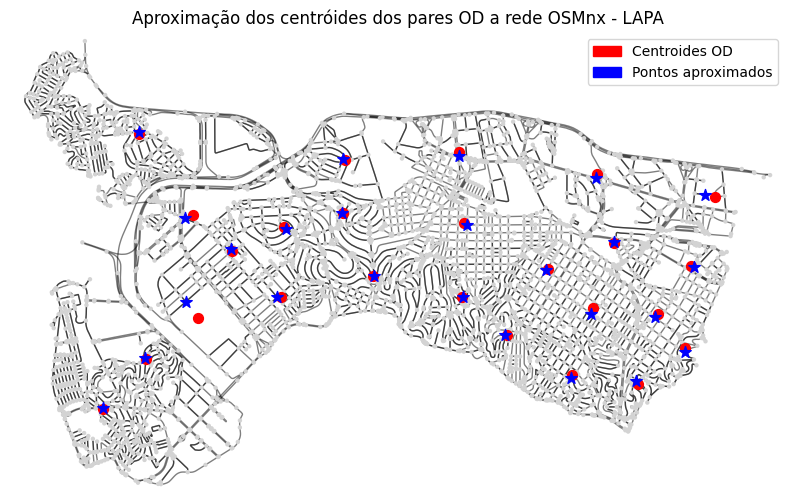

Processamento concluído!


In [29]:
# Definição do CRS UTM para São Paulo
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S

# Ler os dados
print("Carregando dados...")
gdf_OD = gpd.read_file(zonas_shp_OD_2023).to_crs(utm_crs)
gdf_OD_SP = gdf_OD[gdf_OD['NomeMunici'] == 'São Paulo'].copy()
gdf_sp_filtrado = gdf_sp_filtrado.to_crs(utm_crs)

# Iterar sobre cada subprefeitura (aqui, limitado à primeira para teste)
resultados = {}
for idx, subprefeitura in gdf_sp_filtrado.iloc[1:2].iterrows():
    nome_subprefeitura = subprefeitura["sp_nome"]
    print(f"Processando subprefeitura: {nome_subprefeitura}")
    
    # Criar GeoDataFrame da subprefeitura (em UTM)
    gdf_subpref_utm = gpd.GeoDataFrame(geometry=[subprefeitura["geometry"]], crs=utm_crs)
    
    # Converter para EPSG:4326 para extrair a rede com OSMnx (se necessário)
    if gdf_subpref_utm.crs.to_epsg() != 4326:
        gdf_subpref_4326 = gdf_subpref_utm.to_crs(epsg=4326)
        poligono = gdf_subpref_4326.iloc[0].geometry
    else:
        poligono = subprefeitura["geometry"]

    # Extrair o grafo para a área do polígono e adicionar velocidades (km/h)
    G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
    G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)
    
    # Projetar o grafo para UTM
    G_baseline_utm = ox.project_graph(G_baseline, to_crs=utm_crs)
    
    # Cria um GeoDataFrame com os centróides dos pontos OD
    gdf_OD_centroids = gdf_OD_SP.copy()
    gdf_OD_centroids["centroide"] = gdf_OD_centroids.geometry.centroid
    # Importante: definir o CRS como o utm_crs, pois os dados já foram convertidos
    gdf_OD_centroids = gpd.GeoDataFrame(gdf_OD_centroids, geometry="centroide", crs=utm_crs)
    
    # Define o polígono da subprefeitura para a junção espacial
    subpref_polygon = gdf_subpref_utm

    # Realiza a junção espacial para identificar os centróides dentro da subprefeitura
    gdf_centroids_in_subpref = gdf_OD_centroids.sjoin(subpref_polygon, how="inner", predicate="within")
    
    # Agora, usamos os centróides que caíram dentro da subprefeitura
    centroides_df = gdf_centroids_in_subpref.copy()
    
    # Aproximar os pontos à rede: encontrar o nó mais próximo para cada centroide
    coluna_nome = f"nearest_node_{nome_subprefeitura.replace(' ', '_')}"
    centroides_df[coluna_nome] = centroides_df.geometry.apply(
        lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
    )
    
    # Obter coordenadas dos nós aproximados
    centroides_df["node_x"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["x"])
    centroides_df["node_y"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["y"])
    
    # Criar GeoDataFrame com os nós aproximados
    gdf_nos_aproximados = gpd.GeoDataFrame(
        centroides_df,
        geometry=gpd.points_from_xy(centroides_df["node_x"], centroides_df["node_y"]),
        crs=utm_crs
    )
    
    # Armazenar resultado
    resultados[nome_subprefeitura] = gdf_nos_aproximados
    
    # Plotar: grafo, centróides originais e nós aproximados
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax já criado
    fig, ax = ox.plot_graph(
        G_baseline_utm, ax=ax, node_color='lightgray', node_size=10,
        edge_color='black', edge_alpha=0.5, show=False, close=False
    )

    # Plota os centróides dos pontos OD (apenas os que estão dentro da subprefeitura)
    centroides_df.plot(ax=ax, marker='o', color='red', markersize=50, label='Centroides OD', zorder=3)

    # Plota os pontos aproximados (nós da rede)
    gdf_nos_aproximados.plot(
        ax=ax, marker='*', color='blue', markersize=75,
        label='Pontos aproximados', zorder=4
    )
    
    plt.title(f'Aproximação dos centróides dos pares OD a rede OSMnx - {nome_subprefeitura}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Cria legendas
    legenda_centroides = mpatches.Patch(color='red', label='Centroides OD')
    legenda_aprox = mpatches.Patch(color='blue', label='Pontos aproximados')
    plt.legend(handles=[legenda_centroides, legenda_aprox])
    
    plt.show()

# Combinar todos os GeoDataFrames em um único
resultado_final = gpd.GeoDataFrame(pd.concat(resultados.values(), ignore_index=True))

print("Processamento concluído!")


### Funções de apoio

In [ ]:
def filtrar_centroides_por_subprefeitura(gdf_zonas, gdf_subprefeituras, subprefeitura, utm_crs):
    """
    Filtra os centroides das zonas OD que estão dentro de uma determinada subprefeitura.

    Parâmetros:
    - gdf_zonas: GeoDataFrame das zonas OD
    - gdf_subprefeituras: GeoDataFrame das subprefeituras, contendo a coluna 'sp_nome'
    - subprefeitura: Nome da subprefeitura a ser filtrada
    - utm_crs: Sistema de referência de coordenadas UTM a ser usado

    Retorna:
    - Um GeoDataFrame contendo os centroides filtrados
    """

    # Atribuir o esquema de projeção
    gdf_zonas_utm = gdf_zonas.to_crs(utm_crs)

    # Filtrar para o município de São Paulo
    gdf_zonas_sp = gdf_zonas_utm[gdf_zonas_utm['NomeMunici'] == 'São Paulo'].copy()

    # Criar a coluna de centroides
    gdf_zonas_sp["centroid"] = gdf_zonas_sp["geometry"].centroid

    # Garantir que ambos os GeoDataFrames têm o mesmo CRS
    gdf_zonas_sp = gdf_zonas_sp.to_crs(gdf_subprefeituras.crs)

    # Criar um GeoDataFrame com os centroides
    centroids_gdf = gpd.GeoDataFrame(gdf_zonas_sp[['centroid']], geometry='centroid', crs=gdf_subprefeituras.crs)

    # Realizar o spatial join para adicionar a subprefeitura a cada centróide
    centroids_filtrados = gpd.sjoin(centroids_gdf, gdf_subprefeituras[['geometry', 'sp_nome']], how='inner', predicate='within')

    # Filtrar para a subprefeitura específica
    centroids_filtrados = centroids_filtrados[centroids_filtrados['sp_nome'] == subprefeitura]

    return centroids_filtrados

def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node2, 'NumeroZona'].values[0]
    #print(f'O número de viagens entre {zone1} e {zone2} é {od_matrix.loc[zone1, zone2]}')
    return od_matrix.loc[zone1, zone2]

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

def verificar_pendencias_lote(diretorio_raiz, pacote_inicio, pacote_fim, subprefeitura=None):
    """
    Verifica pendências de processamento para um intervalo de pacotes, 
    opcionalmente focando em uma subprefeitura específica.

    Parâmetros:
    - diretorio_raiz: caminho onde está o status_pacotes.csv
    - pacote_inicio: nome do primeiro pacote (ex: 'Pacote_01')
    - pacote_fim: nome do último pacote (ex: 'Pacote_05')
    - subprefeitura: (opcional) nome da subprefeitura para filtrar pendências

    Retorna:
    - Um DataFrame com os pacotes e subprefeituras pendentes.
    """
    caminho_status = os.path.join(diretorio_raiz, 'status_pacotes.csv')

    subprefeituras = [
        'CASA VERDE-CACHOEIRINHA', 'LAPA', 'SE', 'SANTANA-TUCURUVI',
        'PINHEIROS', 'VILA MARIA-VILA GUILHERME', 'MOOCA',
        'SAO MIGUEL', 'ARICANDUVA-FORMOSA-CARRAO', 'SANTO AMARO'
    ]

    if not os.path.exists(caminho_status):
        raise FileNotFoundError(f"Arquivo de controle não encontrado em: {caminho_status}")

    # Carrega o DataFrame e garante ordenação
    df_status = pd.read_csv(caminho_status, index_col=0).sort_index()

    if pacote_inicio not in df_status.index or pacote_fim not in df_status.index:
        raise ValueError("Pacote inicial ou final não encontrado no arquivo de status.")

    # Filtrar intervalo
    df_lote = df_status.loc[pacote_inicio:pacote_fim]

    # Verificação por subprefeitura específica (corrigida)
    if subprefeitura is not None:
        subprefeitura = str(subprefeitura).strip()

        if subprefeitura and subprefeitura in df_status.columns:
            pendentes = df_lote[df_lote[subprefeitura] == 0][[subprefeitura]]
            print(f"Pendências para a subprefeitura: {subprefeitura}")
        else:
            raise ValueError(f"Subprefeitura '{subprefeitura}' não encontrada.")
    
    else:
        # Verifica múltiplas colunas
        pendentes = df_lote[df_lote[subprefeituras].eq(0)].dropna(how='all', subset=subprefeituras)
        print("Pendências para todas as subprefeituras:")

    print(pendentes)
    return pendentes

import logging

def configurar_logging(caminho_log='processamento.log', nivel=logging.INFO):
    """
    Configura logging para exibir mensagens no console e salvar em arquivo.
    
    Parâmetros:
    - caminho_log: caminho do arquivo de log
    - nivel: nível mínimo de log (default: logging.INFO)
    """
    logger = logging.getLogger()
    logger.setLevel(nivel)

    # Remover handlers antigos
    if logger.hasHandlers():
        logger.handlers.clear()

    # Criar formato para log
    formato_arquivo = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    formato_console = logging.Formatter('%(message)s')

    # Handler para arquivo
    file_handler = logging.FileHandler(caminho_log)
    file_handler.setFormatter(formato_arquivo)

    # Handler para console
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formato_console)

    # Adicionar handlers ao logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

import os
import pandas as pd
from tqdm import tqdm
import logging

def processar_pendencias(
    diretorio_raiz,
    pacote_inicio,
    pacote_fim,
    edges_baseline_reprojected,
subprefeitura=None,
    threshold=70,
    threshold_max=300,
    status_filename='status_pacotes.csv'
):
    """
    Processa os pacotes e subprefeituras com status pendente (valor 0) dentro de um intervalo.

    Parâmetros:
    - diretorio_raiz: pasta onde estão os pacotes e o arquivo de status
    - pacote_inicio: string, exemplo 'Pacote_01'
    - pacote_fim: string, exemplo 'Pacote_05'
    - subprefeitura: (opcional) subprefeitura única a ser processada
    - status_filename: nome do arquivo de status (default: status_pacotes.csv)
    """
    # Configura logging (arquivo + console)
    log_path = os.path.join(diretorio_raiz, 'processamento.log')
    configurar_logging(caminho_log=log_path)
    logging.info("🚀 Iniciando processamento de pendências")

    # Caminho do arquivo de status
    caminho_status = os.path.join(diretorio_raiz, status_filename)

    # Obter pendências
    pendencias = verificar_pendencias_lote(
        diretorio_raiz,
        pacote_inicio,
        pacote_fim,
        subprefeitura=subprefeitura
    )

    # Carregar status atual para edição
    df_status = pd.read_csv(caminho_status, index_col=0)

    # Total de tarefas pendentes
    total = (pendencias == 0).sum().sum()

    # Loop com barra de progresso
    with tqdm(total=total, desc="Processando pendências") as pbar:
        for pacote in pendencias.index:
            for sp in pendencias.columns:
                if pendencias.loc[pacote, sp] == 0:
                    try:
                        logging.info(f"🔄 Iniciando: {pacote} | {sp}")
                        print(f"🔄 Processando {pacote} | {sp}")

                        arquivos, caminho = listar_arquivos_tif_ordenados(diretorio_raiz, pacote, subprefeitura)
                        #print(f"Arquivos: {arquivos}")
                        #print(f"Caminho: {caminho}")
                        edges_baseline_reprojected = ajustar_velocidades_com_rasters(
                                                                                    arquivos,
                                                                                    caminho,
                                                                                    edges_baseline_reprojected,
                                                                                    threshold=threshold,
                                                                                    threshold_max=threshold_max,
                                                                                    verbose=True
                                                                                    )
                        #print(edges_baseline_reprojected.columns)
                        
                        # TODO: Inserir aqui o processamento real
                        # Exemplo:
                        # processar_pacote_subprefeitura(pacote, sp)

                        # Marca como concluído
                        df_status.loc[pacote, sp] = 1
                        logging.info(f"✔️ Concluído: {pacote} | {sp}")
                    
                    except Exception as e:
                        logging.error(f"❌ Erro ao processar {pacote} | {sp}: {e}")
                    
                    pbar.update(1)

    # Salvar status atualizado
    df_status.to_csv(caminho_status)
    logging.info("✅ Processamento finalizado e status atualizado.")


In [78]:
import os
import re

def listar_arquivos_tif_ordenados(output_folder, pacote_num, nome_sp):
    """
    Lista arquivos .tif ordenados numericamente a partir de um diretório específico de subprefeitura.
    
    Parâmetros:
    - output_folder: caminho base onde estão os pacotes
    - pacote_num: nome do pacote, ex: 'Pacote_01'
    - nome_sp: nome da subprefeitura, ex: 'LAPA'
    
    Retorna:
    - Lista de arquivos .tif ordenados
    - Caminho completo da pasta onde eles estão
    """
    # Caminho onde estão os arquivos TIFF
    clipado_path = os.path.join(output_folder, pacote_num, 'Sub-prefeituras', nome_sp)

    if not os.path.isdir(clipado_path):
        raise FileNotFoundError(f"❌ O diretório {clipado_path} não foi encontrado.")

    # Listar arquivos .tif válidos
    arquivos_tif = [
        f for f in os.listdir(clipado_path)
        if f.endswith(".tif") and not f.startswith("._")
    ]

    # Função auxiliar para extrair número de nome do arquivo
    def extrair_numero(nome):
        match = re.search(r'(?:h_|max_)(\d+)', nome)
        return int(match.group(1)) if match else float('inf')

    # Ordenar arquivos
    arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

    return arquivos_ordenados, clipado_path

import os
import re
import rasterio

def ajustar_velocidades_com_rasters(
    arquivos_ordenados,
    clipado_path,
    edges_baseline_reprojected,
    threshold,
    threshold_max,
    verbose=True
):
    """
    Aplica ajuste de velocidade em edges a partir de rasters TIFFs ordenados.

    Parâmetros:
    - arquivos_ordenados: lista dos arquivos .tif ordenados
    - clipado_path: caminho onde estão os arquivos
    - edges_baseline_reprojected: GeoDataFrame de edges com colunas de velocidade
    - threshold: limite inferior de aplicação de penalidade
    - threshold_max: limite superior de penalidade (para arquivos _max)
    - verbose: se True, imprime informações detalhadas
    """
    total_arquivos = len(arquivos_ordenados)

    for index, filename in enumerate(arquivos_ordenados, start=1):
        if verbose:
            print(f"\n🔄 Processando arquivo {index} de {total_arquivos}: {filename}")

        match = re.search(r'pct(?P<pct>[\d.]+)_h(?:_max)?_(?P<value>\d+)', filename)

        if verbose and not match:
            print(f"⚠️  Regex não bateu com o nome do arquivo: {filename}")

        if match:
            pct = match.group('pct')
            value = match.group('value')
            is_max = '_max' in filename

            column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
            column_name = column_suffix

            raster_path = os.path.join(clipado_path, filename)

            with rasterio.open(raster_path) as src:
                raster_data = src.read(1)
                raster_transform = src.transform

            # Aplica função de ajuste de velocidade
            edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
                adjust_speed_batch,
                axis=1,
                args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
            )

            # Estatísticas de impacto
            count_zero = (edges_baseline_reprojected[column_name] == 0).sum()
            count_modified = (
                (edges_baseline_reprojected[column_name] != edges_baseline_reprojected["speed_kph"]) &
                (edges_baseline_reprojected[column_name] != 0)
            ).sum()
            count_unchanged = (edges_baseline_reprojected[column_name] == edges_baseline_reprojected["speed_kph"]).sum()

            if verbose:
                print(f"🔧 Velocidades ajustadas para zero: {count_zero} ou {count_zero/len(edges_baseline_reprojected)*100:.2f}%")
                print(f"🟡 Velocidades modificadas: {count_modified} ou {count_modified/len(edges_baseline_reprojected)*100:.2f}%")
                print(f"🟢 Velocidades inalteradas: {count_unchanged} ou {count_unchanged/len(edges_baseline_reprojected)*100:.2f}%")

    if verbose:
        print("\n✅ Processamento de rasters concluído!\n")

    return edges_baseline_reprojected


In [73]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

### Produzir novas referências de velocidade

In [79]:
processar_pendencias(
    diretorio_raiz=diretorio_raiz,
    pacote_inicio='Pacote_01',
    pacote_fim='Pacote_10',
    edges_baseline_reprojected=edges_baseline_reprojected,
    subprefeitura=nome_sp,
    threshold=70,
    threshold_max=300,
    status_filename='status_pacotes.csv'
)


🚀 Iniciando processamento de pendências


Pendências para a subprefeitura: LAPA
           LAPA
Pacote_10     0


Processando pendências:   0%|          | 0/1 [00:00<?, ?it/s]🔄 Iniciando: Pacote_10 | LAPA


🔄 Processando Pacote_10 | LAPA

🔄 Processando arquivo 1 de 26: pct10.0_h_3456000_LAPA.tif
🔧 Velocidades ajustadas para zero: 0 ou 0.00%
🟡 Velocidades modificadas: 0 ou 0.00%
🟢 Velocidades inalteradas: 8640 ou 100.00%

🔄 Processando arquivo 2 de 26: pct10.0_h_3459600_LAPA.tif
🔧 Velocidades ajustadas para zero: 394 ou 4.56%
🟡 Velocidades modificadas: 380 ou 4.40%
🟢 Velocidades inalteradas: 7866 ou 91.04%

🔄 Processando arquivo 3 de 26: pct10.0_h_3463200_LAPA.tif
🔧 Velocidades ajustadas para zero: 524 ou 6.06%
🟡 Velocidades modificadas: 398 ou 4.61%
🟢 Velocidades inalteradas: 7718 ou 89.33%

🔄 Processando arquivo 4 de 26: pct10.0_h_3466800_LAPA.tif
🔧 Velocidades ajustadas para zero: 575 ou 6.66%
🟡 Velocidades modificadas: 425 ou 4.92%
🟢 Velocidades inalteradas: 7640 ou 88.43%

🔄 Processando arquivo 5 de 26: pct10.0_h_3470400_LAPA.tif
🔧 Velocidades ajustadas para zero: 686 ou 7.94%
🟡 Velocidades modificadas: 453 ou 5.24%
🟢 Velocidades inalteradas: 7501 ou 86.82%

🔄 Processando arquivo 6 de

✔️ Concluído: Pacote_10 | LAPA
Processando pendências: 100%|██████████| 1/1 [00:12<00:00, 12.68s/it]
✅ Processamento finalizado e status atualizado.


🔧 Velocidades ajustadas para zero: 1937 ou 22.42%
🟡 Velocidades modificadas: 327 ou 3.78%
🟢 Velocidades inalteradas: 6376 ou 73.80%

✅ Processamento de rasters concluído!

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'junction',
       'access', 'width', 'tunnel', 'pct10.0_h_3456000', 'pct10.0_h_3459600',
       'pct10.0_h_3463200', 'pct10.0_h_3466800', 'pct10.0_h_3470400',
       'pct10.0_h_3474000', 'pct10.0_h_3477600', 'pct10.0_h_3481200',
       'pct10.0_h_3484800', 'pct10.0_h_3488400', 'pct10.0_h_3492000',
       'pct10.0_h_3495600', 'pct10.0_h_3499200', 'pct10.0_h_3502800',
       'pct10.0_h_3506400', 'pct10.0_h_3510000', 'pct10.0_h_3513600',
       'pct10.0_h_3517200', 'pct10.0_h_3520800', 'pct10.0_h_3524400',
       'pct10.0_h_3528000', 'pct10.0_h_3531600', 'pct10.0_h_3535200',
       'pct10.0_h_3538800', 'pct10.0_h_3542400_max', 'pct10.0_h_3542400'],
      dtype='object')


In [70]:
pendencias = verificar_pendencias_lote(diretorio_raiz, 'Pacote_01', 'Pacote_02', nome_sp)

pacote_num = 'Pacote_01'

# Construir o caminho completo do diretório onde estão os arquivos TIFF
clipado_path = os.path.join(output_folder, pacote_num, 'Sub-prefeituras', nome_sp)

# Verificar se o diretório existe antes de continuar
if not os.path.isdir(clipado_path):
    raise FileNotFoundError(f"O diretório {clipado_path} não foi encontrado.")

# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif") and not f.startswith("._")]

# Total de arquivos a serem processados
total_arquivos = len(arquivos_tif)

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

Pendências para a subprefeitura: LAPA
Empty DataFrame
Columns: [LAPA]
Index: []


NameError: name 'output_folder' is not defined